# Lab 3 Report:
## Surpass Human Performance in Fashion MNIST Classificaion

In [180]:
import matplotlib.pyplot as plt
import torch
import numpy as np

In [181]:
from IPython.display import Image # For displaying images in colab jupyter cell

In [182]:
# Image('lab4_exercise.png', width = 1000)

## Prepare Data

In [183]:
# Load Fashion-MNIST Dataset in Numpy

# 10000 training features/targets where each feature is a greyscale image with shape (28, 28)
train_features = np.load('fashion_mnist_train_features.npy')
train_targets = np.load('fashion_mnist_train_targets.npy')

# 1000 testing features/targets
test_features = np.load('fashion_mnist_test_features.npy')
test_targets = np.load('fashion_mnist_test_targets.npy')

# Let's see the shapes of training/testing datasets
print("Training Features Shape: ", train_features.shape)
print("Training Targets Shape: ", train_targets.shape)
print("Testing Features Shape: ", test_features.shape)
print("Testing Targets Shape: ", test_targets.shape)

Training Features Shape:  (10000, 28, 28)
Training Targets Shape:  (10000,)
Testing Features Shape:  (1000, 28, 28)
Testing Targets Shape:  (1000,)


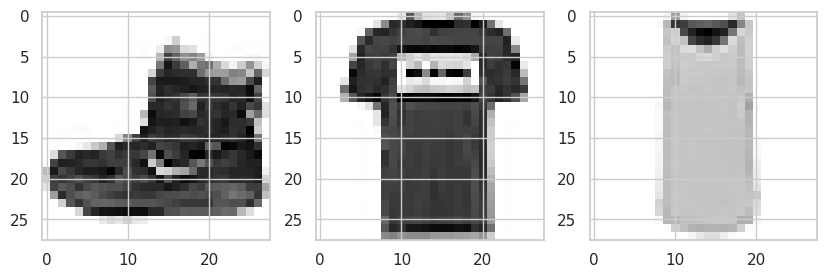

In [184]:
# Visualizing the first three training features (samples)

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(train_features[2], cmap = 'Greys')

In [185]:
# Perform standard scaling on the training and testing features
# After scaling, make sure you reshape the training features back to (10000, 28, 28) and testing features to (1000, 28, 28)
# since CNNs take 2D tensors as inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_features = scaler.fit_transform(train_features.reshape(10000, 784)).reshape(10000, 28, 28)
test_features = scaler.fit_transform(test_features.reshape(1000, 784)).reshape(1000, 28, 28)

In [186]:
# Take the first 1000 (or randomly select 1000) training features and targets as validation set

from sklearn.model_selection import train_test_split

train_features, validation_features, train_targets, validation_targets = train_test_split(train_features,
                                                                                          train_targets,
                                                                                          train_size=0.9,
                                                                                          random_state=1)


In [187]:
# Reshape train/validation/test sets to conform to PyTorch's (N, Channels, Height, Width) standard for CNNs

train_features =  np.reshape(train_features, (9000, 1, 28, 28))
validation_features = np.reshape(validation_features, (1000, 1, 28, 28))
test_features = np.reshape(test_features, (1000, 1, 28, 28))

## Define Model

In [188]:
# Define your CNN architecture here

class CNNModel(torch.nn.Module):

    def __init__(self, input_channels=1):

        super(CNNModel, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = torch.nn.BatchNorm2d(32)
        self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.pool1 = torch.nn.MaxPool2d(2)


        self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = torch.nn.BatchNorm2d(64)
        self.conv4 = torch.nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.conv5 = torch.nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = torch.nn.BatchNorm2d(128)
        self.conv6 = torch.nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.fc1 = torch.nn.Linear(128 * 3 * 3, 512)
        self.bn4 = torch.nn.BatchNorm1d(512)
        self.drop1 = torch.nn.Dropout(0.3)

        self.fc2 = torch.nn.Linear(512, 256)
        self.bn5 = torch.nn.BatchNorm1d(256)
        self.drop2 = torch.nn.Dropout(0.3)

        self.fc3 = torch.nn.Linear(256, 10)


    def forward(self, x):

        # Note: If you are using CrossEntropyLoss() do NOT apply softmax to the final ouput
        # since it's incorporated within the loss function
        x = torch.nn.functional.relu(self.bn1(self.conv1(x)))
        x = torch.nn.functional.relu(self.bn1(self.conv2(x)))
        x = self.pool1(x)

        x = torch.nn.functional.relu(self.bn2(self.conv3(x)))
        x = torch.nn.functional.relu(self.bn2(self.conv4(x)))
        x = self.pool1(x)

        x = torch.nn.functional.relu(self.bn3(self.conv5(x)))
        x = torch.nn.functional.relu(self.bn3(self.conv6(x)))
        x = self.pool1(x)

        x = torch.flatten(x, 1)
        x = torch.nn.functional.relu(self.bn4(self.fc1(x)))
        x = self.drop1(x)

        x = torch.nn.functional.relu(self.bn5(self.fc2(x)))
        x = self.drop2(x)

        x = self.fc3(x)

        return x

## Select Hyperparameters

In [189]:
# Fix the random seed so that model performance is reproducible
torch.manual_seed(55)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Initialize your CNN model

model = CNNModel().to(device)

# Define learning rate, epoch and batchsize for mini-batch gradient

learning_rate = 1e-3
epochs = 30
batchsize = 64

# Define loss function and optimizer

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model

CNNModel(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=1152, out_features=512, bias=True)
  (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (drop1): Dropout(

## Identify Tracked Values

## Train Model

In [190]:
import tqdm

def train(model,
          batch_split_num,
          train_batches_features,
          train_batches_targets,
          validation_inputs,
          validation_targets,
          test_inputs,
          test_targets):

    # For each mini-batch number k, grab k-th training feature mini-batch and target mini-batch
    # and perform fwd/bwd pass on the network

    loss_list = []

    for k in range(batch_split_num):

        optimizer.zero_grad()

        train_batch_outputs = model(train_batches_features[k])

        loss = loss_func(train_batch_outputs, train_batches_targets[k])

        loss_list.append(loss.item())

        loss.backward()

        optimizer.step()

    # Compute Validation Accuracy ----------------------------------------------------------------------

    with torch.no_grad():

        validation_outputs = model(validation_inputs)

        correct = (torch.argmax(validation_outputs, dim=1) ==
                validation_targets).type(torch.FloatTensor)

        test_outputs = model(test_inputs)
        test_correct = (torch.argmax(test_outputs, dim=1) ==
                test_targets).type(torch.FloatTensor)

        return loss_list, correct.mean(), test_correct.mean()


In [191]:
# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
# Make sure to shuffle training dataset for each epoch to incorporate cross-validation during training
# Split your training features/targets into mini-batches if using mini-batch gradient

train_inputs = torch.from_numpy(train_features).float().to(device)
train_targets = torch.from_numpy(train_targets).long().to(device)

testing_inputs = torch.from_numpy(test_features).float().to(device)
testing_targets = torch.from_numpy(test_targets).long().to(device)

validation_inputs = torch.from_numpy(validation_features).float().to(device)
validation_targets = torch.from_numpy(validation_targets).long().to(device)



In [192]:
train_loss_list = []
validation_accuracy_list = []

# Training Loop ---------------------------------------------------------------------------------------
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

for epoch in tqdm.trange(epochs):
    train_batches_features = torch.split(train_inputs, batchsize)
    train_batches_targets = torch.split(train_targets, batchsize)
    batch_split_num = len(train_batches_features)

    loss_list, val_acc, test_acc = train(model=model,
          batch_split_num=batch_split_num,
          train_batches_features=train_batches_features,
          train_batches_targets=train_batches_targets,
          validation_inputs=validation_inputs,
          validation_targets=validation_targets,
          test_inputs=testing_inputs,
          test_targets=testing_targets)

    train_loss_list.extend(loss_list)
    validation_accuracy_list.append(val_acc)

    scheduler.step()


100%|██████████| 30/30 [00:30<00:00,  1.01s/it]


## Visualize & Evaluate Model

In [193]:
# Seaborn for prettier plot

import seaborn as sns

sns.set(style = 'whitegrid', font_scale = 1)

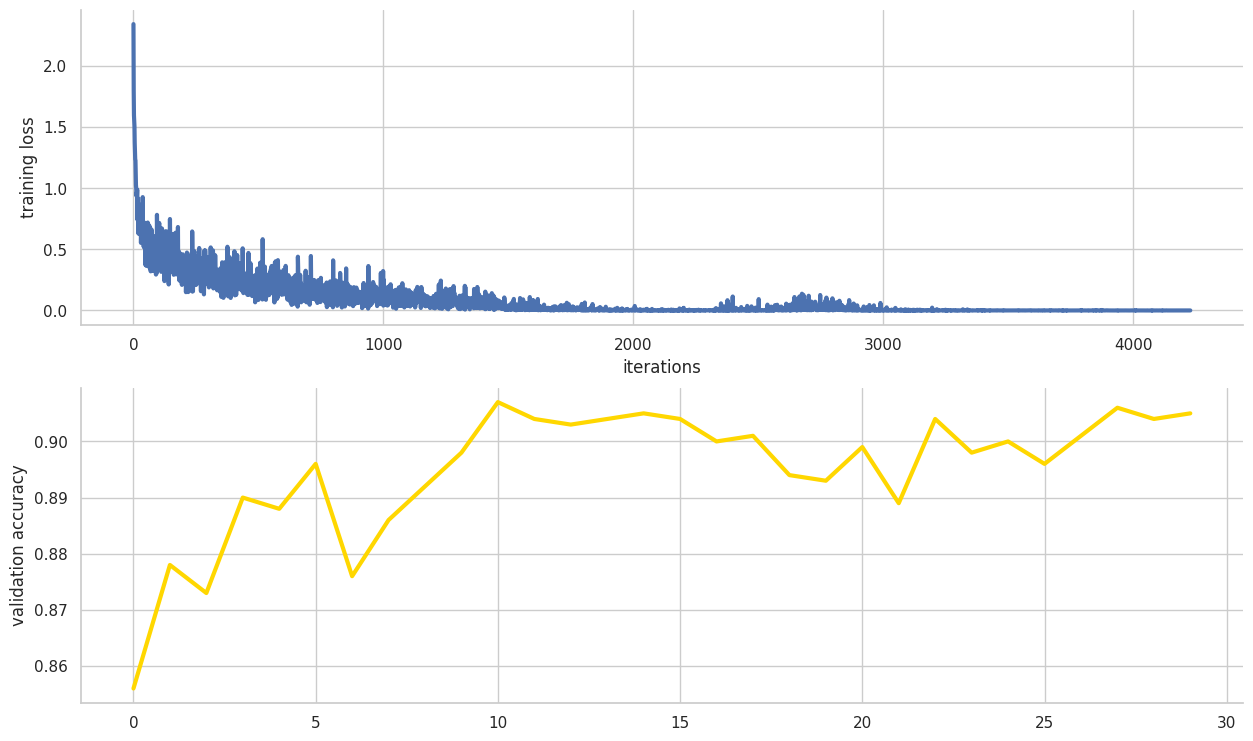

In [197]:
# Visualize training loss

plt.figure(figsize = (15, 9))

plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("iterations")
sns.despine()

plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color='gold')
plt.ylabel("validation accuracy")
sns.despine()

In [195]:
# Compute the testing accuracy

# Compute the testing accuracy


with torch.no_grad():

    y_pred_test = model(testing_inputs)

    correct = (torch.argmax(y_pred_test, dim=1) == testing_targets).type(torch.FloatTensor)

    print(f'Testing accuracy: {correct.mean()}')

Testing accuracy: 0.9070000052452087


In [196]:
# Print the testing accuracy for each fashion class. Your code should produce something that looks like:

# "Accuracy of T-shirt/top: 93.5 %"
# "Accuracy of Trouser: 89.3 %"
# etc...

# What's the fashion item that your model had the hardest time classifying?

# YOUR CODE HERE

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

correct_per_class = [0] * 10
total_per_class = [0] * 10

with torch.no_grad():
    outputs = model(testing_inputs)
    _, predicted = torch.max(outputs, 1)
    for label, prediction in zip(testing_targets, predicted):
        total_per_class[label] += 1
        if label == prediction:
            correct_per_class[label] += 1

print("\nTest Accuracy per class:")
accuracies = []
for i in range(10):
    accuracy = 100 * correct_per_class[i] / total_per_class[i]
    accuracies.append(accuracy)
    print(f"{class_names[i]:<12}: {accuracy:.2f}%")

print(f"The model is best at classifying {class_names[np.argmax(accuracies)]}s with a testing accuracy of {np.max(accuracies).round(2)}%\nand worst at classifying {class_names[np.argmin(accuracies)]}s with a testing accuracy of {np.min(accuracies).round(2)}%.")


Test Accuracy per class:
T-shirt/top : 87.85%
Trouser     : 97.14%
Pullover    : 84.68%
Dress       : 87.10%
Coat        : 81.74%
Sandal      : 96.55%
Shirt       : 80.41%
Sneaker     : 97.89%
Bag         : 96.84%
Ankle boot  : 94.74%
The model is best at classifying Sneakers with a testing accuracy of 97.89%
and worst at classifying Shirts with a testing accuracy of 80.41%.
